In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, RocCurveDisplay, roc_auc_score

# Description
- 

# Data
- https://archive.ics.uci.edu/dataset/267/banknote+authentication

In [50]:
seed = 42
# https://archive.ics.uci.edu/dataset/267/banknote+authentication
df = pd.read_csv('..\\..\\data\\data_banknote_authentication.csv')

ycols = 'class'
xcols = [name for name in df.columns if name not in ycols]

# Split data into train and test sets
X = df[xcols]
Y = df['class']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

all_names =[]
all_perf = {'F1':[],
            'AUC':[]}

In [51]:
def get_predictions(model):
    # train the model on the features (X) and target labels (Y)
    model.fit(X_train, Y_train)
    # with the trained model, take in the test values and try to predict some Y values
    prediction = model.predict(X_test)
    return get_table(model, prediction)

#separated because of gridCV pedantics
def get_table(model, prediction):
    # creates a data frame with one column ("pred") that stores all of the predictions
    out_df = pd.DataFrame(columns=['pred'], data=prediction)
    # append the data frame with a new column ("prob") that holds the
    # calculated probability of each value by the model
    out_df['prob'] = model.predict_proba(X_test)[:,1]
    return out_df

all_names =[]
all_perf = {'F1':[],
            'AUC':[]}

def evaluate(preds, name):
    f1 = f1_score(Y_test, preds['pred'])
    auc = roc_auc_score(Y_test, preds['prob'])

    print("\n", name, ": ")
    print(classification_report(preds['pred'], Y_test))
    print("F1 = ", f1)
    print("AUC = ", auc)

    print()
    all_names.append(name)
    all_perf['F1'].append(f1)
    all_perf['AUC'].append(auc)

    # RocCurveDisplay.from_predictions(val[ycols], preds['prob'])
    # plt.grid()
    # plt.axis('equal')
    # plt.show()

# Prepare base pipeline with preprocessing
numeric_transformer = Pipeline([
    # ('imputer', SimpleImputer(strategy='mean')) - no NA values so no need
    ('scaler', StandardScaler())
])
# No need for ColumnTransformer as all data is numeric

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf = Pipeline([
    ('pre', numeric_transformer),
    ('model', RandomForestClassifier(n_estimators=100,
                                     min_samples_split=20,
                                     min_samples_leaf=5,
                                     n_jobs=1))
])
name = 'Random forest classifier'
evaluate(get_predictions(rf), name)


 Random forest classifier : 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       149
           1       0.98      0.99      0.99       126

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275

F1 =  0.9881422924901185
AUC =  0.9992019578633752



In [53]:
from sklearn.linear_model import LogisticRegression
lr = Pipeline([
    ('pre', numeric_transformer),
    ('model', LogisticRegression(random_state=seed, intercept_scaling=0.5, max_iter=10000))
])
name = 'Logistic regression'
evaluate(get_predictions(lr), name)


 Logistic regression : 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       146
           1       0.98      0.97      0.98       129

    accuracy                           0.98       275
   macro avg       0.98      0.98      0.98       275
weighted avg       0.98      0.98      0.98       275

F1 =  0.9765625
AUC =  0.9994679719089169



In [54]:
from sklearn.tree import DecisionTreeClassifier
dtc = Pipeline([
    ('pre', numeric_transformer),
    ('model', DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=seed))
])
name = "Decision tree classifier"
evaluate(get_predictions(dtc), name)


 Decision tree classifier : 
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       158
           1       0.85      0.92      0.89       117

    accuracy                           0.90       275
   macro avg       0.89      0.90      0.90       275
weighted avg       0.90      0.90      0.90       275

F1 =  0.8852459016393442
AUC =  0.9616673760374548



In [55]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':['rbf', 'poly', 'linear'],
            'C':[0.1, 1, 10], 'gamma':[1, 0.1, 0.001]}
name = "SVM found with GS"
gs_svm = Pipeline([
    ('pre', numeric_transformer),
    ('SVM', GridSearchCV(estimator=SVC(probability=True), param_grid=parameters, scoring='roc_auc'))
])
evaluate(get_predictions(gs_svm), name)


 SVM found with GS : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       127

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275

F1 =  1.0
AUC =  1.0



In [ ]:
from sklearn.ensemble import VotingClassifier
models = []
name = "Ensemble (hard)"


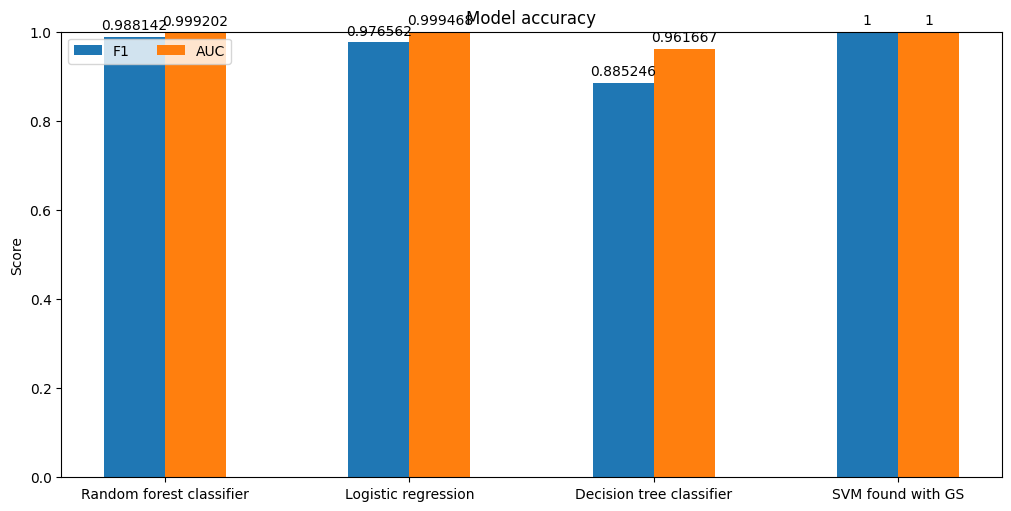

In [61]:
x = np.arange(len(all_names))
width = 0.25
multiplier = 0.5

fig, ax = plt.subplots(layout = 'constrained', figsize = (10, 5))

for attribute, measurement in all_perf.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label = attribute)
    ax.bar_label(rects, padding = 3)
    multiplier +=1

ax.set_ylabel('Score')
ax.set_title('Model accuracy')
ax.set_xticks(x + width, all_names)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 1)

plt.show()